# COGS 118A - Final Project

# Insect Classification 

## Group members

- Tyden Rucker
- Areen Lu
- Anya Bodhisartha
- Nikhil Deepak
- Jason Xu

# Abstract 
Pests are one of the main issues in the agricultural industry we have today. If left unchecked, they can damage plants, food supplies, and property. According to the research, using machine learning improves the accuracy of insect detection than the traditional insect identification method. In this project, we are aiming to classify and detect insect pests that have greatly affected agricultural products. Additionally, we want to measure the accuracy of different machine learning methods. The data are images which are already classified and labeled. Using this data, we will be processing the data then constructing a model to create a multi-class classifier and use mean squared error or cross validation to compare different models. Utilizing different evaluation metrics such as precision and recall and cross validation, we will determine the best hyperparameters and model. Our project will focus on model selection as well as algorithm selection to determine the best model that accurately predicts the class of the insect given an image.



# Background

Agriculture is a substantial aspect of the world economy making up 5.4% of the United States GDP in 2021. This percentage amounts to $1.264 trillion.<a name="USDA"></a>[<sup>[1]</sup>](#USDA)The performance of the agricultural sector has wide ranging ramifications and implications in all parts of everyday life. 

Insects are a critical component of the agricultural ecosystem. From major pollinators such as bees and mosquitoes to pests such as aphids, some insects provide vital services to farmers while others could possibly be detrimental to the survival of a crop and subsequently the livelihood of surrounding settlements. Large quantities of pests such as grasshoppers, locusts, and caterpillars can result in widespread damage to crops and potentially lead to famine.Traditionally, identifying and managing insects and pests has relied on labor intensive and time consuming methods. Farmers and other agricultural experts would visually inspect plants and use insecticides based on general knowledge of common insects. However, these approaches are limited in accuracy and efficiency, leading to environmental risks. Using machine learning for insect recognition helps solve these problems, as they process large amounts of image data. Farmers can benefit from improved accuracy and efficiency in pest management decisions. Accurate pest identification enables farmers to respond more effectively to threats, reducing the risk of crop damage and financial losses. 

Previous studies conducted on similar datasets, such as 9 and 24 insect classes of Wang and Xie datasets, enhanced, augmented and rescaled the images. Shape features, including area, perimeter, axis lengths, eccentricity, and compactness were then extracted from the insect images and stored in feature models. ANN, SVM, KNN, CNN (Convolutional Neural Network) and NB (Naive Bayes) algorithms were applied to classify the insects, and their performance was evaluated.<a name="Insect Classification"></a>[<sup>[2]</sup>](#InsectClass) The CNN model had the highest classification accuracy of 91.5\% and 90\% for the Wang and Xie datasets. Another study by Xie et al. used a 19-layer CNN network which outperformed previous state-of-the-art models on the same task.<a name="National"></a>[<sup>[4]</sup>](#National)

It is significant to understand the optimal ways to identify insects. There are many ways to conduct insect classification, both traditional or through machine learning. However, machine learning provides an optimal solution that can be utilized to improve accuracy and efficiency of predictions. 

# Problem Statement

It is difficult to identify pests with traditional methods or machine learning methods that are not suitable for image processing. The multilayer perceptron (MLP) or Linear Discriminant Analysis or Convolutional Neural Network are models that will be focused on for this problem. MLP is a supervised learning method that is mainly used for pattern recognition. The Linear Discriminant Analysis is another method used for data classification. A convolutional neural network may perform the best for extracting data from our data. Our dataset consists of images that are correctly classified already. Our model aims to learn from this data set through supervised machine learning in order to correctly recognize patterns within the images and label them accordingly.

# Data

We will be utilizing the IP102 Dataset<a name="IP102"></a>[<sup>[3]</sup>](#IP102). This dataset consists of 75,222 images and 102 classes of insects. It averages 737 samples/images per class. This data set already has a split of 6:1:3. To improve training time and reduce computational demand, we reduced the dataset to the first 10 classes, keeping the same dataset structure and training/testing/validation splits. 

The insects are of varying sizes and location within the image and therefore these placements might pose as critical variables for classifying an image. The labels are represented through one hot encoding in order to create labels that have a uniform effect on the measurement of the loss. Some special handlings that will be implemented is that the images will be scaled to a fixed input size in order to minimize the space used by each image. Time augmentation will be used where images will be altered, shifted, flipped, and color shifted. The critical variables will be extracted from the image during training.

The resize_all function loads train, test, and val images from a path, resizes them, and writes them to a dictionary as arrays with labels. These dictionaries are saved as variable `arr`, which is used to extract train and test data for the Random Forest classifier.



In [6]:
#!pip install opendatasets 
#!pip install pandas
#!pip install timm
#!pip install opencv-python
#!pip install jupyter_contrib_nbextensions
#!pip install jupyter_nbextensions_configurator

In [7]:
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4) 
from tqdm import tqdm
from textwrap import wrap
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2

import timm

import opendatasets as od
import pandas
#od.download('https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset/code?select=classification')

The issue with this dataset is that due to the large sum of data and the high dimensionality of the inputs, the model is hard to make computationally efficient and iterations take a long time to run. Our preliminary base model is a Resnet34 which is a convolutional neural network that utilizes residual blocks to take in an input image of 34x34 and output a classification. All input images are resized into a 34x34 image in order to feed this into the NN. 

In [8]:
data_path = 'ip02-dataset-10labels/classification'
def resample(dataFrame,percentage,):
    sample = int(percentage * len(dataFrame))
    x = np.random.randint(len(dataFrame),size =sample)
    newdf = dataFrame.drop(index = x, axis=0)
    return newdf
train_df = pd.read_csv('ip02-dataset-10labels/train.txt',sep=' ',header=None, engine='python')
train_df = train_df.sample(frac=.10)
train_df.columns = ['image_path','label']
test_df = pd.read_csv('ip02-dataset-10labels/test.txt',sep=' ',header=None, engine='python')
test_df = test_df.sample(frac=.10)
test_df.columns = ['image_path','label']
val_df = pd.read_csv('ip02-dataset-10labels/val.txt',sep=' ',header=None, engine='python')
val_df = val_df.sample(frac=.10)
val_df.columns = ['image_path','label']
train_df.head()
TRAIN_DIR = 'ip02-dataset-10labels/classification/train'
TEST_DIR = 'ip02-dataset-10labels/classification/test'
VAL_DIR = 'ip02-dataset-10labels/classification/val'
LR = 2e-5
BATCH_SIZE = 4
EPOCH = 2
print_every = 100
dtype = torch.float32
device = torch.device('cuda')

In [9]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

The data is also transformed in a variety of psuedo random ways. The transforms that are applied to the input data are; a random vertical flip, a random adjustment to the sharpness, a random horizontal flip and color jitter. These flip transformations are used to increase the datasets size during training and also reduce overfitting and introduce diversity allowing the model to better generalize.

In [10]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [11]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=data_transform)
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=data_transform)
valid_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

Here is our sample images from the dataset which has already been resized.

In [12]:
import opendatasets as od
import pandas
data_path = 'ip02-dataset-10labels/classification'

In [13]:
#Resize
def resize_all(src, width=224, height=None):
    height = height if height is not None else width
     
    traindata = dict()
    traindata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    traindata['label'] = []
    traindata['filename'] = []
    traindata['data'] = []   
    testdata = dict()
    testdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    testdata['label'] = []
    testdata['filename'] = []
    testdata['data'] = []   
    valdata = dict()
    valdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    valdata['label'] = []
    valdata['filename'] = []
    valdata['data'] = []   
    dicts = [testdata,traindata,valdata]
    y = 0
    for subdir in os.listdir(src):
        current_path = os.path.join(src, subdir)
        directory = current_path
        for subdir2 in os.listdir(current_path):
            current_path = os.path.join(directory, subdir2)
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    dicts[y]['label'].append(subdir2)
                    dicts[y]['filename'].append(file)
                    dicts[y]['data'].append(im)
        y += 1
    return dicts

In [14]:
arr = resize_all(data_path)

In [15]:
labels = {'labels':[0, 1, 2,3,4,5,6,7,8,9],'classes':['rice leaf roller','rice leaf caterpillar','paddy stem maggot',' asiatic rice borer  ','yellow rice borer','rice gall midge','Rice Stemfly','brown plant hopper','white backed plant hopper','small brown plant hopper']}
labels = pd.DataFrame(labels)
labels

,labels,classes
0,0,rice leaf roller
1,1,rice leaf caterpillar
2,2,paddy stem maggot
3,3,asiatic rice borer
4,4,yellow rice borer
5,5,rice gall midge
6,6,Rice Stemfly
7,7,brown plant hopper
8,8,white backed plant hopper
9,9,small brown plant hopper


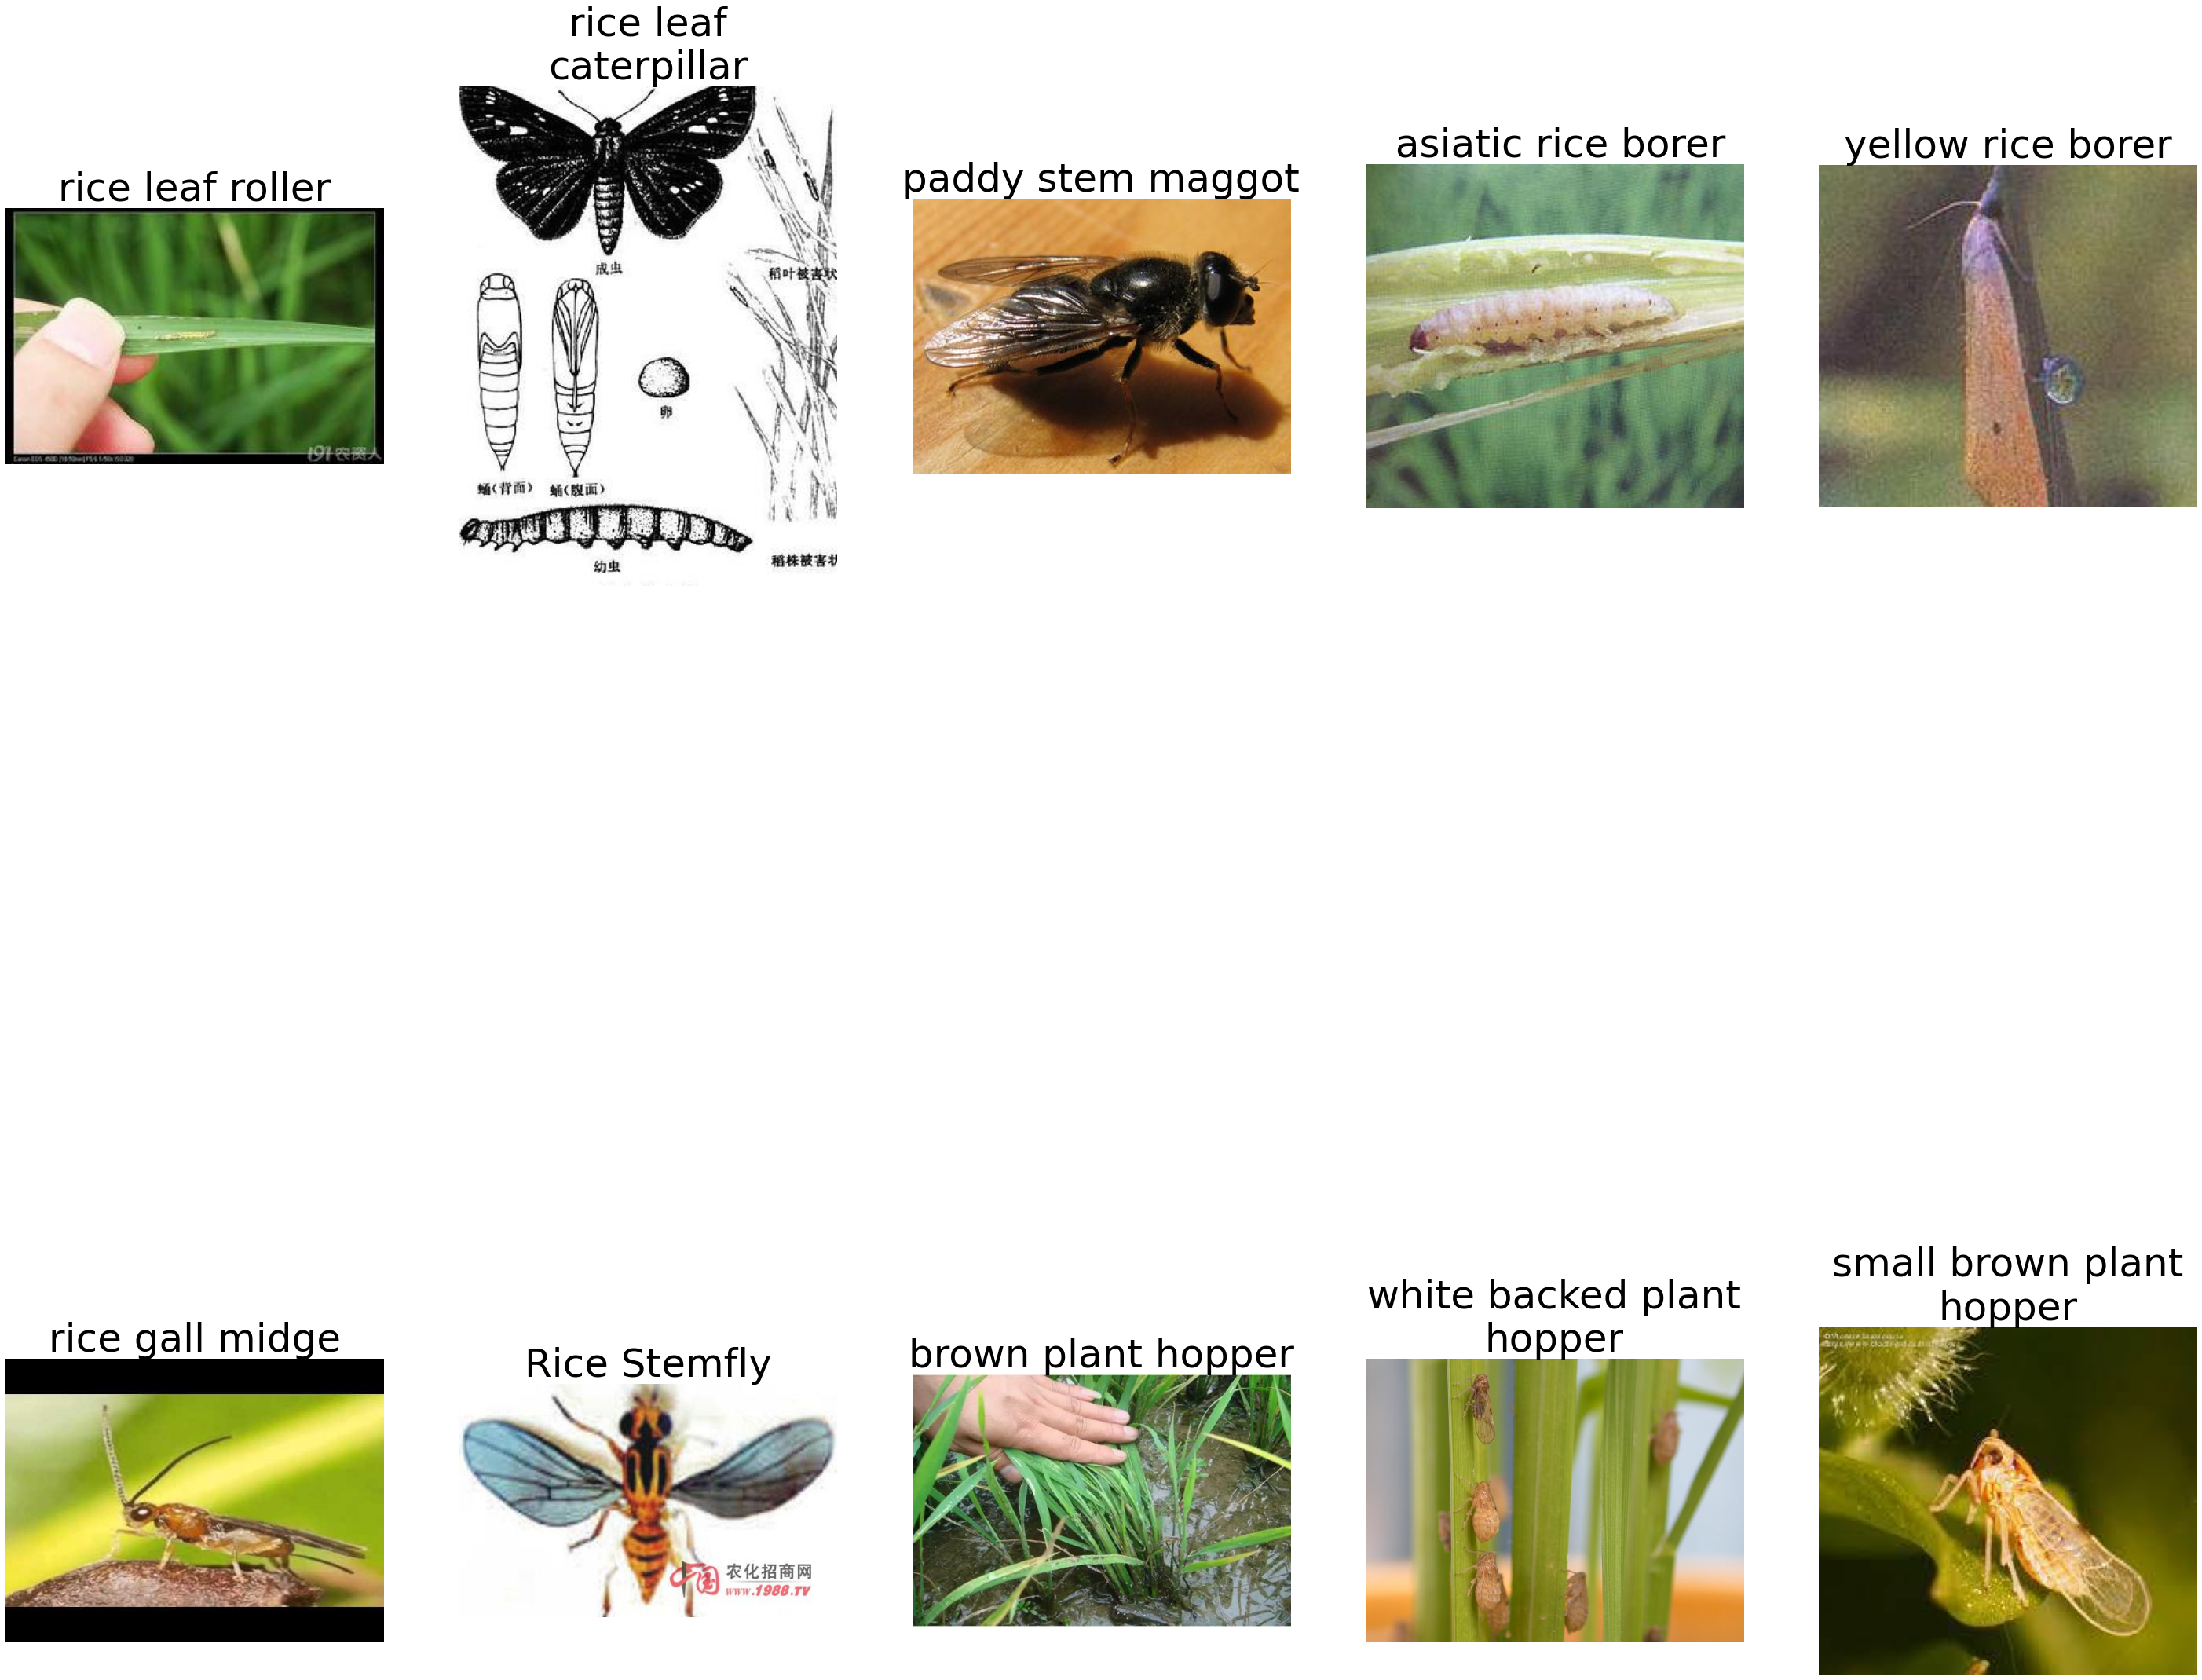

In [16]:
fig, axs = plt.subplots(2,5,figsize=(50,50))
images = []
for i in labels.labels:
    random_img = random.choice(train_df[train_df.label==i].image_path.values)
    label = labels.classes[i]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20)),fontsize = 50) for label,ax in zip(list(labels.classes),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

# Proposed Solution

It is essential to establish a strong connection to the problem at hand. In this case, correctly identifying insects in farming scenarios is crucial for pest control, determining optimal cultivation practices, and minimizing crop damage. By accurately classifying insects, farmers can take targeted actions and make informed decisions to optimize crop yield and reduce economic losses. The correct classification of insects is crucial for effective farming of crops from an economic perspective. To achieve this, we will employ an image classifier, such as a convolutional neural network (CNN) which is a multiclass classifier and by creating our own (explained below). By utilizing multiway classifiers, we take an input image and accurately classify it into predefined classes within the dataset.

To construct a multiclass classifier, we will leverage different models like Linear Discriminant Analysis (LDA) and a neural network with a Multi-Layer Perceptron (MLP), aka CNN. The Sklearn library provides convenient methods for building these models and creating a classifier. It offers various options for the number of layers and solvers, allowing us to experiment and optimize the performance of the classifier.

It's important to highlight the effectiveness of image classifiers in handling complex visual data. CNNs, in particular, excel at extracting features from images, enabling accurate classification, and combined with the use of LDA, allows us to handle multiple classes and make predictions accordingly.

The data set that we are currently using contains a training, test, and validation set, allowing us to perform rigorous testing and evaluation. Cross-validation techniques, such as k-fold validation, will also be applied to assess the generalization capability of the models.

To establish a benchmark for testing our solution, we can utilize models that have shown high performance on similar tasks. One such model is AlexNet, which achieved impressive results on the ImageNet dataset, a large-scale image classification benchmark. By comparing the performance of our model against AlexNet, we can assess its effectiveness and determine areas for improvement.

# Evaluation Metrics

We will be using a confusion matrix as an evaluation metric for this project. Utilizing Precision and recall taken from the confusion matrix will allow us to create evaluation metrics. Additionally, we will use AlexNet, which is the benchmark model used for image classification.

The formulas included in this project:
\begin{align*}
Precision: \frac{TP}{TP + FP}\\
Recall: \frac{TP}{TP + FN}\\
Accuracy: \frac{TP + TN}{TP + TN + FP + FN}\\
F1: \frac{2*Precision * Recall}{Precision + Recall}
\end{align*}


# Results

In the result section, we will discuss the procedures of data handling and machine learning algorithms used to classify and evaluate our results. Sections include:

- Train-Test-Split
- Data Preprocessing
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Random Forest Classification

## Train-Test-Split

In [ ]:
x_train = arr[1]['data']
print(x_train[0].flatten())
for i in range(len(x_train)):
    x_train[i] = x_train[i].flatten()
#print(flatten(x_train[0]))
#for i in range(len(x_train)):
    #flatten(x_train[i])
#x_train = flatten(x_train)
y_train = arr[1]['label']
y_trainneigh = arr[1]['label']
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
x_train = SelectKBest(f_classif, k = 2).fit_transform(x_train,y_train)
#neigh = KNeighborsClassifier(n_neighbors= 2)
#neigh.fit(x_train,y_train)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_train,y_train, test_size = 0.33, random_state = 42)
#print(X_train)


[0.81679859 0.81400326 0.80616012 ... 0.99245448 0.99445028 0.89773581]


The code above first assigns the 'data' array from the second element of the 'arr' array to the variable 'x_train'. It then prints the flattened representation of the first element in 'x_train'. Next, a loop is used to flatten each element within 'x_train'. It then assigns the 'label' array from the second element of 'arr' to the variable 'y_train'. Following this, feature selection is applied to 'x_train' using the SelectKBest method from scikit-learn. This method selects the two best features based on the f_classif (ANOVA F-value) score. The data is then split into training and testing sets using the train_test_split function from scikit-learn. The training set is assigned to 'X_train' and 'y_train', while the testing set is assigned to 'X_test' and 'y_test'.

## Data Preprocessing

The dataset has first been shrunken to 10 labels instead of 102 preserving the training-validation-test split. This was to reduce the computation time of the problem and allow time to explore more models and methods instead. As the dataset has high dimensionality due to the fact that the images are in RGB and have shapes of 224x224x3, the first step for preprocessing this data was to decrease the dimensionality through flattening each image into a 1 x D array, although this increases the amount of features, it allows us to train models such as Random Forests and KNN much quicker. Once the array has been flatten we also proceed to further process the data through using the SelectKBest method from the sklearn library. The SelectKBest method was used in order to select different features from the dataset that best contributed to predicting their labels, for K we used K = 2 which used the best 2 features. The SelectKBest method works through defining a scorer and then using that metric in order to rank the features based on that metric. The scorer that was chosen was the f_classif scorer that utilizes the ANOVA F-values of the features in order to rank the features based on those F-values. After processing the data and conducting feature selection, the data is now prepared to be trained on the different chosen models.  

In [ ]:
x_test = arr[0]['data']
for i in range(len(x_test)):
    x_test[i] = x_test[i].flatten()
y_test = arr[0]['label']
y_testneigh = arr[0]['label']
y_pred = neigh.predict(x_test)

## Logistic Regression

Logistic regression is a type of discriminative model commonly used for binary classification tasks, where it estimates the probability of an event occurring or not occurring. However, it can also be extended to handle multiple classes by using the "multinomial" setting (`multi_class='multinomial’`). This model establishes a relationship between input variables and the output, which can take on values of 0 or 1. By leveraging this relationship, logistic regression calculates the likelihood of belonging to each class, resulting in a probability value between 0 and 1.

In our specific model, we employ logistic regression with multiple classes. To ensure fair comparison, we apply feature scaling to the training data. This scaling process guarantees that each feature has a consistent influence on the image detection process, regardless of their initial ranges. Once the training data is scaled, we fit the logistic regression model to it, allowing it to learn the underlying patterns and relationships.

After the model has been trained, we evaluate its performance by computing the testing accuracy score. This metric indicates how well the model can correctly classify unseen data points from the test dataset. By assessing the accuracy score, we gain insights into the effectiveness of the logistic regression model in predicting the correct classes for the test data.

In [ ]:
from sklearn.linear_model import LogisticRegression
logic = LogisticRegression(multi_class = 'multinomial',solver= 'saga')
from sklearn.preprocessing import scale
x_train = scale(x_train)
logic.fit(x_train,y_train)
print(logic.score(x_test,y_test))

Logistic Regression Test Accuracy: 0.33687405159332323

When dealing with datasets that have multiple classes, training a Logistic Regression model can be challenging. In such cases, the model's performance tends to deteriorate significantly, resulting in slower training times and lower accuracy. This problem arises because Logistic Regression needs to perform multiple "one versus rest" operations, which can be computationally intensive. Additionally, as the number of classes increases, the model has to handle a larger number of parameters, further exacerbating the issue.

For instance, in our specific scenario, the Logistic Regression model achieved a testing accuracy of only 33% after fitting for a duration of 30 minutes. This outcome highlights the difficulties inherent in training Logistic Regression on datasets with multiple classes. Consequently, the model's performance is notably compromised, making it an impractical choice, particularly for datasets like the original 102-label IP-02 dataset, which entail an even greater number of classes.

## K-Nearest Neighbors (KNN)

In [ ]:
acc = []
Big_N = [1,3,5,7,9,10,25,50]
for i in Big_N:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train,y_trainneigh)
    acc.append(neigh.score(x_test,y_testneigh))

In the given code, we aimed to establish a baseline by shifting from our initial solution of employing a Convolutional Neural Network (CNN) to a more traditional approach. In this alternative approach, we utilized a K-Nearest Neighbors (KNN) classifier to determine the classes of the preprocessed data points.

By applying the KNN algorithm with K=1, we achieved a 50% accuracy on the test dataset, as depicted in the accompanying graph. This result provides a starting point for future research and iterations. It suggests that there is potential to improve the performance by creating an ensemble of KNN classifiers that outperform chance-level predictions. Such an ensemble would combine multiple KNN models, leveraging their individual strengths, and is expected to yield superior results compared to a single base model.

One advantage of using an ensemble of KNN models is that it remains computationally inexpensive compared to more complex models like CNNs. This computational efficiency allows for easier experimentation and iteration in the pursuit of enhanced accuracy. 

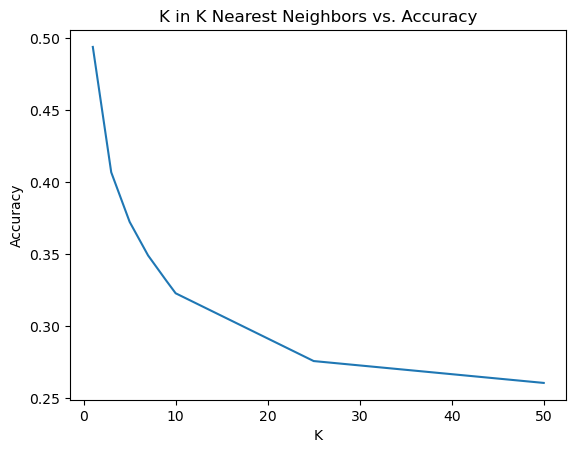

The iteration involving multiple KNN models, although initially intended as a baseline, offers valuable insights into the behavior and organization of the data. The fact that certain K values improve the accuracy indicates that there are similarities between the test set and the training set, enabling effective classifications to be made. One of the benefits of training a KNN model is its computational efficiency. The calculations involved are relatively quick, primarily consisting of computing the Euclidean or Manhattan distance between data points. These distances are then ranked, and the class with the most votes (plurality vote) determines the final classification. KNN models possess several advantages. They are easily interpretable, allowing us to understand and analyze the decision-making process. Furthermore, KNN does not assume any specific shape for the data, making it suitable for creating classifiers that do not have linear or polynomial decision boundaries. Additionally, KNN enables the clustering of data points into multiple classes, making it a versatile option for classification tasks.


## Random Forest Classification

Random forest classification is one of the most popular machine learning algorithms because it can handle both classification and regression problems. Additionally, it has a fast training speed and is known to handle classification and regression problems with high accuracy. With these facts in mind, we choose a random forest classifier as one of our algorithms. In this step, we will introduce random forest classifiers and show the difference between the training set and test set in detail.

### Training

In our implementation, we begin by training a random forest classifier. We then utilize this trained classifier to predict the labels for the training data. Subsequently, we calculate and plot the confusion matrix, which provides valuable insights into the performance of the classifier.

During the process of specifying hyperparameters, we experiment with various values to determine their impact on the training accuracy. In particular, we explore the effect of increasing the number of estimators in the random forest. We initially set the baseline number of estimators to 100 and gradually increase it up to 1000. Simultaneously, we also evaluate the accuracy when reducing the number of estimators. Through this exploration, we identify the optimal number of estimators to be 1000, as it allows us to train the ensemble with high accuracy.

To visualize the confusion matrix, we employ a heatmap. This visualization technique enhances our understanding by providing a clear representation of both the accuracy and the errors made by the classifier. By using a heatmap, we can visually grasp the distribution of correct and incorrect predictions, facilitating the identification of patterns and areas where the classifier may struggle.

In [ ]:
def accuracy(tn,fp,fn,tp):
    return (tn+tp)/(fn+fp+tn+tp)
from sklearn.ensemble import RandomForestClassifier
print(len(X_train))
print(len(X_test))
l = RandomForestClassifier(random_state=0,n_estimators= 1000).fit(X = X_train,y = y_train)
y_pred = l.predict(X_train)
print(l.score(X_train,y_train))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=l.classes_)
disp.plot()
plt.show()
#tn, fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
#print(accuracy(tn, fp,fn,tp))

### Training Results

Following the tuning of hyperparameters, we achieved an impressive training accuracy of 97%. This high training accuracy suggests that the model fits the training data well and captures the underlying patterns effectively. However, it is important to note that relying solely on training accuracy is not sufficient to evaluate the model's overall performance.

To obtain a more comprehensive assessment, we must also evaluate the testing accuracy of the model. Testing accuracy measures the model's ability to generalize and make accurate predictions on unseen data. It serves as a crucial metric for determining the model's performance beyond the training dataset.

Evaluating testing accuracy is essential for several reasons. Firstly, it allows us to identify potential overfitting, which occurs when a model performs exceedingly well on the training data but fails to generalize to new data. Testing accuracy provides insights into how well the model performs on unseen examples, helping us detect any signs of overfitting.

Additionally, testing accuracy helps us understand the model's generalization capability. Achieving high accuracy on the testing data demonstrates that the model has learned meaningful and transferable patterns, rather than memorizing the training data.

### Testing
To evaluate the performance of a random forest classifier on test data, we conduct a grid search to identify the optimal hyperparameters. This involves systematically exploring various hyperparameter combinations and selecting the best set based on a defined evaluation metric. Once the best classifier is identified, we apply it to the test data and generate a confusion matrix. The confusion matrix provides insights into the model's performance by presenting the true and predicted labels, enabling us to assess the accuracy and identify any misclassifications. Visualizing the confusion matrix helps in understanding the distribution of predictions across different classes, aiding in model evaluation and decision-making.

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf.fit(x_train, y_train)
#print(clf.score(x_test,y_test))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)
                                      )
                                      }
]
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(clf.score(X_test,y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=l.classes_)
disp.plot()
plt.show()

### Testing Results 
The obtained accuracy score of 17.45% for the testing data indicates that the classification model's performance is quite low, with only a small proportion of the samples being correctly predicted compared to the total number of samples in the test set. This suggests that the model is likely overfitting, meaning it is excessively tailored to the training data and struggles to generalize well to unseen data. The low accuracy score suggests that the model may be capturing noise or specific patterns present in the training data that do not hold true in the broader context. 

# Discussion

### Interpreting the result

Throughout the project, we performed multiple model selection on our data. Here is our interpretations:
 
#### - Logistic Regression takes an unreasonably long runtime and low accuracy compared to other models

   Despite employing the 'saga' solver and dedicating a 30-minute fitting process, our model yielded a testing accuracy of only 33%. This outcome underscores the challenges encountered when training a Logistic Regression model on datasets with multiple classes. The time-consuming nature of training a Logistic Regression model in this scenario can be attributed to the requirement of performing multiple one-versus-rest operations. Each class is treated as the positive class, while the remaining classes are treated as the negative class. This process significantly adds to the computational overhead, resulting in longer training times. Furthermore, Logistic Regression introduces a larger number of parameters to account for the multiple classes. This further complicates the training process and can hinder the model's accuracy and performance. As the number of classes increases, the limitations of Logistic Regression become more apparent. Its suitability for handling multi-class classification tasks diminishes, as it struggles to scale efficiently and deliver satisfactory results. This is particularly evident when considering datasets like the original 102-label IP-02 dataset, which involve a larger number of classes. In such cases, alternative models, such as neural networks or Random Forest, are often preferred for their improved scalability and performance in multi-class classification tasks. These models can better handle the complexities of the data, offering superior accuracy and efficiency compared to Logistic Regression.

#### - KNN has a decent accuracy on the test set, but performed well on the training set

We divided our dataset into a 66% training set and a 33% test set and proceeded to apply the KNN algorithm. Our model achieved a 50% accuracy on the test set when using K = 1, while obtaining a training accuracy of 90%. This discrepancy suggests that the model may be overfitting the training data, resulting in lower performance on unseen test data. Based on our dataset, it appears that selecting a lower value of K tends to yield higher accuracy scores. In our case, choosing K = 1 resulted in a 50% accuracy. To further explore the performance, we employed the Euclidean distance metric and determined the final classification through plurality voting. KNN proves to be a viable classifier for our task, as it provides relatively quick results and is straightforward to use. However, due to its simplicity, there is a higher risk of encountering missing data. It is important to note that KNN may struggle with datasets that contain complex patterns or require more sophisticated decision boundaries. Our experimentation with KNN demonstrated that it can be employed as a classifier, delivering results with a short runtime and ease of use. However, it is essential to be cautious about potential overfitting and missing data, as well as understanding its limitations in handling complex datasets.

#### - Random Forest Ensemble has a highest training accuracy rate compared to other, but slightly overfit

The accuracy of the Random Forest on the training set is exceptionally high, slightly overfitting, and our research attempts to mitigate that through optimizing parameters such as the max depth of trees in the ensemble.The Random Forest model exhibits exceptionally high accuracy on the training set, indicating a potential issue of slight overfitting. To address this concern, our research focuses on optimizing various parameters, such as the maximum depth of the trees in the ensemble. By fine-tuning these parameters, we aim to mitigate the overfitting problem and improve the model's generalization performance on unseen data.


### Limitations 

Due to limitations in hardware resources, including personal computers and the datahub servers, training large models with multiple epochs was not feasible within the provided timeframe. The training times for each epoch exceeded an hour for the entire dataset consisting of 102 labels. Consequently, utilizing more accurate and complex models such as multilayer models and neural networks, as well as conducting extensive hyperparameter optimization, was not possible.

To address the hardware limitations, the dataset was reduced to only 10 labels, resulting in significantly reduced training times. However, this reduction in labels came at the expense of classifying a smaller number of distinct labels, limiting the model's capability to differentiate between a wider range of insect classes. Moreover, inconsistencies in the number of images for each insect class within the dataset further impacted the accuracy of classifying specific labels. The limited diversity of the training data might have made it challenging for the models to effectively detect outliers and generalize to unseen instances.

Another observation is that the Random Forest classifier exhibited slight overfitting, leading to a noticeable disparity between the training and testing accuracies. Overfitting occurs when a model becomes too specialized to the training data and struggles to generalize well to unseen data. This discrepancy in performance suggests that the model might have learned to memorize and fit the training data too closely, compromising its ability to accurately classify new instances.

In summary, due to hardware limitations, the use of more sophisticated models, extensive hyperparameter tuning, and training on the complete dataset was not feasible. The reduction in labels and overfitting in the Random Forest classifier further impacted the classification accuracy, emphasizing the importance of balancing computational constraints, dataset diversity, and model generalization.

  

### Ethics & Privacy 

The dataset used in our project is publicly available on Kaggle, ensuring transparency and eliminating concerns regarding data security and retention. The dataset primarily relies on the top 2000 search engine results for insect names, which helps minimize potential collection bias. The images in the dataset exclusively feature insects, eliminating any issues related to human subjects, privacy, consent, discrimination, personally identifiable information, or protected group status.

Our project employs a Random Forest classifier, which is a highly flexible and explainable model. It allows us to select various evaluation metrics and provides insights into feature importance. To represent the model's performance honestly and accurately, we utilize a confusion matrix, which offers a clear visual representation of the model's predictions and errors.

Given the potential consequences of misclassifying insects, such as mistakenly identifying non-harmful insects as pests and resulting in excessive pesticide usage, we recognize the importance of addressing algorithmic errors. To mitigate such risks, we advocate for the implementation of an ongoing feedback system. This would enable us to continuously improve the model and reduce the chances of future inaccuracies. The code's modularity and visibility of performance metrics facilitate making necessary adjustments based on feedback and evolving requirements.

Our project aligns with the guidelines outlined by the DEON (Data Ethics Decision Aid) framework, ensuring ethical considerations are taken into account in terms of data availability, algorithm transparency, potential implications, and the possibility of incorporating user feedback for model improvement.

(With reference to guidelines from https://deon.drivendata.org/)


### Conclusion 

The purpose of this project is to find optimal solutions for insect classification which would highly benefit agricultural industry. We performed multiple models including logistic regression, KNN, and random forest classifiers. 

At the beginning of our project, we experimented with ResNet34 and ResNet18, which are types of convolutional neural networks (CNNs), to analyze the suitability of deep learning algorithms for solving the problem at hand. However, due to the multiple layers of data in the form of images, training and testing these models resulted in unreasonably long runtimes. Moreover, the accuracy of these models was compromised, possibly due to the challenges in effectively training and optimizing deep neural networks with numerous layers.

To address these issues, we attempted to implement a Three Layer Convolutional Network. However, this particular model performed poorly on the dataset, failing to achieve satisfactory results in terms of classification accuracy.

Consequently, we decided to explore alternative models that could better handle the characteristics of the dataset and provide improved performance. By shifting our focus to other model architectures and techniques, we aimed to find a suitable solution that could effectively classify the insect images while ensuring manageable runtimes and reasonable accuracy.

As we compared all models, we found that random forest classifiers are the optimal solution to identify pests as we got the positive indication on accuracy. However, it is alluded to as an overfit. We believe that this result can be investigated further with the potential overfitting factor and perform more research on models to get an accurate result without overfitting. Even though the model performance is nearly flawless, this project could serve as the tool to help people understand the importance of pest identification and eventually become helpful in solving the pests issue.  

### Above and Beyond (Extra Credit)

During our project, which drew upon concepts from the class "Supervised Machine Learning Algorithms (COGS 118A)," we encountered significant challenges. Our initial focus was on image classification, aiming to explore the relationship between machine learning and pattern analysis in images. While we covered the fundamentals of image classification in class, we delved deeper into the concept and its application within machine learning.

One of the major challenges we faced was the large dataset, which required over an hour to process. To address this, we resorted to resizing the dataset twice, reducing its computational demands. However, as we made numerous changes to our work, we had to repeatedly rerun the entire code, leading to additional time and effort.

Another obstacle we encountered was selecting the appropriate algorithm for our task. We experimented with Convolutional Neural Networks (CNNs) such as ResNet34 and ResNet18, but their extensive pattern recognition capabilities and complex layers resulted in long runtimes. We also attempted to implement K-nearest neighbors (KNN), but encountered errors or obtained illogical outcomes during our coding attempts.

Despite these challenges, we eventually obtained an optimal solution, albeit with a slight overfitting issue. We recognize that further research and hands-on coding experience are necessary to decrease the runtime while achieving effective and accurate results.

Our project involved overcoming challenges related to dataset size and algorithm selection. We addressed these issues by resizing the dataset and exploring various algorithms such as CNNs and KNN. Although we obtained an optimal solution, there is still room for improvement, which can be achieved through continued research and gaining more experience in coding and optimizing machine learning models.






# Footnotes
1.^: United States Department of Agriculture (2 Dec 2022) What is agriculture's share of the overall U.S. economy. United States Department of Agriculture. https://www.ers.usda.gov/data-products/chart-gallery/gallery/chart-detail/?chartId=58270
2.^: Thenmozhi Kasinathan, Dakshayani Singaraju, Srinivasulu Reddy Uyyala, Insect classification and detection in field crops using modern machine learning techniques, Information Processing in Agriculture, Volume 8, Issue 3, 2021, Pages 446-457, ISSN 2214-3173, https://doi.org/10.1016/j.inpa.2020.09.006. (https://www.sciencedirect.com/science/article/pii/S2214317320302067)
3.^: Ratul Mahjabin (2022) IP102-Dataset https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset?select=test.txt
4.^: Xia D, Chen P, Wang B, Zhang J, Xie C. Insect Detection and Classification Based on an Improved Convolutional Neural Network. Sensors (Basel). 2018 Nov 27;18(12):4169. doi: 10.3390/s18124169. PMID: 30486481; PMCID: PMC6308804.